## tesing dataloader V5

new ideas with ordinal c and yc 
has ordinal binary and continous outputs

In [1]:
# Load dependencies
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split



from utils.graph import *
from utils.loss_ordinal import *
from utils.tram_model_helpers import *
from utils.tram_models import *
from utils.tram_data import *


import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

Train with GPU support.


adjustet funcitnos for ordinal outcomes 

dev ordinal

In [2]:
experiment_name = "testing_v5_dataloader"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
df = pd.DataFrame({
    "x1": np.random.normal(loc=0, scale=1, size=1000),
    # "x2": np.random.uniform(low=0, high=10, size=1000),
    "ord_bin1":  np.random.binomial(1, p=0.4, size=1000),
    "ord_multi": np.random.choice([0, 1, 2, 3], size=1000, p=[0.2, 0.3, 0.3, 0.2]),
    "ord_bin2":  np.random.binomial(1, p=0.4, size=1000),
})

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

In [4]:
### New Functions and classes


def create_levels_dict_v2(df:pd.DataFrame,data_type:dict):
    # creates the levels dictionary for variables which should be modelled ordinaly 
    levels_dict={}
    for variable,datatype in data_type.items():
            if "ordinal" in datatype.lower():
                unique_vals = set(df[variable].dropna().unique())
                num_classes = len(unique_vals)

                expected_vals = set(range(num_classes))
                if unique_vals != expected_vals:
                    raise ValueError(
                        f"Variable '{variable}' has values {sorted(unique_vals)}, "
                        f"but expected values are {sorted(expected_vals)} (0 to {num_classes - 1}). "
                        "Multiclass ordinal variables must be zero-indexed and contiguous."
                )
                levels_dict[variable]=len(np.unique(df[variable]))
    return levels_dict   




def create_node_dict_v3(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals,levels_dict=None):
    """
    Creates a configuration dictionary for TRAMADAG based on an adjacency matrix,
    a neural network names matrix, and a data type dictionary.
    """
    if not validate_adj_matrix(adj_matrix):
        raise ValueError("Invalid adjacency matrix. Please check the criteria.")
    
    if len(data_type) != adj_matrix.shape[0]:
        raise ValueError("Data type dictionary should have the same length as the adjacency matrix.")
    
    target_nodes = {}
    G, edge_labels = create_nx_graph(adj_matrix, node_labels=list(data_type.keys()))
    
    sources = [node for node in G.nodes if G.in_degree(node) == 0]
    sinks = [node for node in G.nodes if G.out_degree(node) == 0]
    
    for i, node in enumerate(G.nodes):
        parents = list(G.predecessors(node))
        target_nodes[node] = {}
        target_nodes[node]['Modelnr'] = i
        target_nodes[node]['data_type'] = data_type[node]
        
        # write the levels of the ordinal outcome
        if 'ordinal' in data_type[node]:
            if levels_dict is None:
                raise ValueError(
                    "levels_dict must be provided for ordinal nodes; "
                    "e.g. levels_dict={'x3': 3}"
                )
            if node not in levels_dict:
                raise KeyError(
                    f"levels_dict is missing an entry for node '{node}'. "
                    f"Expected something like levels_dict['{node}'] = <num_levels>"
                )
            target_nodes[node]['levels'] = levels_dict[node]
    
        target_nodes[node]['node_type'] = "source" if node in sources else "sink" if node in sinks else "internal"
        target_nodes[node]['parents'] = parents
        target_nodes[node]['parents_datatype'] = {parent:data_type[parent] for parent in parents}
        target_nodes[node]['transformation_terms_in_h()'] = {parent: edge_labels[(parent, node)] for parent in parents if (parent, node) in edge_labels}
        target_nodes[node]['min'] = min_vals.iloc[i].tolist()   
        target_nodes[node]['max'] = max_vals.iloc[i].tolist()

        
        transformation_term_nn_models = {}
        for parent in parents:
            parent_idx = list(data_type.keys()).index(parent)  
            child_idx = list(data_type.keys()).index(node) 
            
            if nn_names_matrix[parent_idx, child_idx] != "0":
                transformation_term_nn_models[parent] = nn_names_matrix[parent_idx, child_idx]
        target_nodes[node]['transformation_term_nn_models_in_h()'] = transformation_term_nn_models
    return target_nodes



In [5]:

# datatype= "ordinal_Xc_Yc" # as X its continous aswell as Y continous
# datatype= "ordinal_Xc_Yo"
# datatype= "ordinal_Xn_Yc"
# datatype= "ordinal_Xn_Yo"


In [6]:
def preprocess_inputs_v2(x, transformation_terms, device='cuda'):
    """
    Prepares model input by grouping features by transformation term base:
      - ci11, ci12 → 'ci1' (intercept)
      - cs11, cs12 → 'cs1' (shift)
      - cs21 → 'cs2' (another shift group)
      - cs, ls → treated as full group keys
    Returns:
      - int_inputs: Tensor of shape (B, n_features) for intercept model
      - shift_list: List of tensors for each shift model, shape (B, group_features)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    transformation_terms=list(transformation_terms)
    
    ## if there is only a source so transforamtion terms is 0:
    x = [xi.to(device, non_blocking=True) for xi in x]
    if len(transformation_terms)== 0:
        x = [xi.unsqueeze(1) for xi in x] 
        int_inputs= x[0]
        return int_inputs, None

    # Always ensure there's an intercept term
    if not any('ci' in str(value) for value in transformation_terms):
        transformation_terms.insert(0, 'si')

    # Lists to collect intercept tensors and shift‐groups
    int_tensors = []
    shift_groups = []

    # Helpers to track the “current” shift‐group for numbered suffixes
    current_group = None
    current_key = None

    for tensor, term in zip(x, transformation_terms):
        # 1) INTERCEPT terms (si*, ci*)
        if term.startswith(('si','ci')):
            int_tensors.append(tensor)

        # 2) SHIFT terms (cs*, ls*)
        elif term.startswith(('cs','ls')):
            # numbered suffix → group by the first 3 chars (e.g. 'cs11'/'cs12' → 'cs1')
            if len(term) > 2 and term[2].isdigit():
                key = term[:3]
                # start a new group if key changed
                if current_group is None or current_key != key:
                    current_group = []
                    shift_groups.append(current_group)
                    current_key = key
                current_group.append(tensor)

            # lone 'cs' or 'ls' → always its own group
            else:
                current_group = [tensor]
                shift_groups.append(current_group)
                current_key = None
        else:
            raise ValueError(f"Unknown transformation term: {term}")

    # Intercept: should be exactly one group
    if len(int_tensors) == 0:
        raise ValueError("No intercept tensors found!")
    int_inputs = torch.cat(
        [t.to(device, non_blocking=True).view(t.shape[0], -1) for t in int_tensors],
        dim=1
    )

    shift_list = [
        torch.cat([t.to(device, non_blocking=True).view(t.shape[0], -1) for t in group], dim=1)
        for group in shift_groups
    ]

    return int_inputs, shift_list if shift_list else None

## new version of dataloasdr v5

In [7]:
class GenericDataset_v5(Dataset):
    def __init__(
        self,
        df,
        target_col,
        target_nodes=None,
        parents_dataype_dict=None,
        transformation_terms_in_h=None,
        return_intercept_shift=True,
        transform=None,
        return_y=True
    ):
        """
        df: pd.DataFrame
        target_col: str
        target_nodes: dict mapping each node → metadata (including 'data_type')
        parents_dataype_dict: dict var_name → "cont"|"ord"|"other"
        transformation_terms_in_h: dict for intercept logic
        return_intercept_shift: whether to return (int_input, shift_list) or raw features
        transform: torchvision transform for images
        """
        self.return_intercept_shift = return_intercept_shift
        self.return_y=return_y
        self.df = df.reset_index(drop=True)
        self.target_col = target_col
        self.target_nodes = target_nodes or {}
        self.parents_dataype_dict = parents_dataype_dict or {}
        self.predictors = list(self.parents_dataype_dict.keys())
        self.transform = transform
        self.transformation_terms_preprocessing = list((transformation_terms_in_h or {}).values())
        self.h_needs_simple_intercept = all('i' not in str(v) for v in self.transformation_terms_preprocessing)
        self.target_data_type = self.target_nodes[self.target_col].get('data_type', '').lower()
        self.target_num_classes = self.target_nodes[self.target_col].get('levels')

        # figure out the intercept and shift terms for preprocessed 
        if return_intercept_shift:
            self._set_intercept_shift_indexes()
            
        self._set_target_is_source()
        self._set_ordinal_numal_classes()
        
        # checks
        self._check_multiclass_predictors_of_df()
        self._check_ordinal_levels()


    def _set_target_is_source(self):
        # set whether the target node is a source node
        self.target_is_source = (self.target_nodes[self.target_col].get('node_type', '').lower() == "source")

    def _set_ordinal_numal_classes(self):
        # sets the number of classes for ordinal predictors
        self.ordinal_num_classes = {
            v: self.df[v].nunique()
            for v in self.predictors
            if "ordinal" in self.parents_dataype_dict[v].lower()
            and "xn" in self.parents_dataype_dict[v].lower()
        }

    def _set_intercept_shift_indexes(self):
        # always inject a simple intercept term if no 'ci' present
        if not any('ci' in t for t in self.transformation_terms_preprocessing):
            self.transformation_terms_preprocessing.insert(0, 'si')

        self.intercept_indices = [
            i for i, term in enumerate(self.transformation_terms_preprocessing)
            if term.startswith(('si', 'ci'))
        ]

        self.shift_groups_indices = []
        current_key = None
        for i, term in enumerate(self.transformation_terms_preprocessing):
            if term.startswith(('cs', 'ls')):
                if len(term) > 2 and term[2].isdigit():
                    grp = term[:3]
                    if not self.shift_groups_indices or current_key != grp:
                        self.shift_groups_indices.append([i])
                        current_key = grp
                    else:
                        self.shift_groups_indices[-1].append(i)
                else:
                    self.shift_groups_indices.append([i])
                    current_key = None

    def _preprocess_inputs(self, x):
        """
        x: List of tensors, each with a dummy batch‑dim at 0
        Returns:
            int_inputs: (B, sum(intercept_dims))
            shift_list: list of (B, sum(dims_per_group)) or None
        """
        # intercept
        its = [x[i] for i in self.intercept_indices]
        if not its:
            raise ValueError("No intercept tensors found!")
        int_inputs = torch.cat([t.view(t.shape[0], -1) for t in its], dim=1)

        # shift‐groups
        shifts = []
        for grp in self.shift_groups_indices:
            parts = [x[i].view(x[i].shape[0], -1) for i in grp]
            shifts.append(torch.cat(parts, dim=1))

        return int_inputs, (shifts if shifts else None)

    def _transform_y(self, row):
        if self.target_data_type == "continous" or "yc" in self.target_data_type:
            return torch.tensor(row[self.target_col], dtype=torch.float32)
        elif self.target_num_classes:
            yi = int(row[self.target_col])
            return F.one_hot(
                torch.tensor(yi, dtype=torch.long),
                num_classes=self.target_num_classes
            ).float().squeeze()
        else:
            raise ValueError(
                f"Cannot encode target '{self.target_col}': "
                f"{self.target_data_type}/{self.target_num_classes}"
            )

    def _check_multiclass_predictors_of_df(self):
        for v in self.predictors:
            dt = self.parents_dataype_dict[v].lower()
            if "ordinal" in dt and "xn" in dt:
                vals = set(self.df[v].dropna().unique())
                if vals != set(range(len(vals))):
                    raise ValueError(
                        f"Ordinal predictor '{v}' must be zero‑indexed; got {sorted(vals)}"
                    )

    def _check_ordinal_levels(self):
        ords = []
        if "ordinal" in self.target_nodes[self.target_col]['data_type']:
            ords.append(self.target_col)
        ords += [
            v for v in self.predictors
            if "ordinal" in self.parents_dataype_dict[v].lower()
            and "xn" in self.parents_dataype_dict[v].lower()
        ]
        for v in ords:
            lvl = self.target_nodes[v].get('levels')
            if lvl is None:
                raise ValueError(f"Ordinal '{v}' missing 'levels' metadata.")
            uniq = sorted(self.df[v].dropna().unique())
            if uniq != list(range(lvl)):
                raise ValueError(
                    f"Ordinal '{v}' values {uniq} != expected 0…{lvl-1}."
                )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x_data = []

        # simple intercept if needed
        if self.h_needs_simple_intercept:
            x_data.append(torch.tensor(1.0))

        ################################ IF target is a source
        if self.target_is_source:
            y = self._transform_y(row)
            if not self.return_intercept_shift:
                if self.return_y:
                    return tuple(x_data), y
                else:
                    return tuple(x_data)
            
            else:
                # batchify & preprocess
                batched = [x.unsqueeze(0) for x in x_data]
                int_in, shifts = self._preprocess_inputs(batched)
                # **squeeze off** our dummy batch‐dim:
                int_in = int_in.squeeze(0)              # -> (n_intercept,)
                shifts = [] if shifts is None else [s.squeeze(0) for s in shifts]
                if self.return_y:
                    return (int_in, shifts), y
                else:
                    return (int_in, shifts)

        ################################ IF target has predictors
        for var in self.predictors:
            dt = self.parents_dataype_dict[var].lower()
            if dt == "continous" or "xc" in dt:
                x_data.append(torch.tensor(row[var], dtype=torch.float32))
            elif "ordinal" in dt and "xn" in dt:
                c = self.ordinal_num_classes[var]
                o = int(row[var])
                x_data.append(
                    F.one_hot(torch.tensor(o, dtype=torch.long), num_classes=c).float().squeeze()
                )
            else:
                img = Image.open(row[var]).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                x_data.append(img)

        # only return the original data without separating them for int and shifts
        if not self.return_intercept_shift:
            if self.return_y:
                y = self._transform_y(row)
                return tuple(x_data), y
            else:
                return tuple(x_data)
        
        # returning already splitted int and shifts
        else:    
            batched = [x.unsqueeze(0) for x in x_data]
            int_in, shifts = self._preprocess_inputs(batched)
            int_in = int_in.squeeze(0)
            shifts = [] if shifts is None else [s.squeeze(0) for s in shifts]
            
            if self.return_y:
                y = self._transform_y(row)
                return (int_in, shifts), y
            else:
                return (int_in, shifts)


def get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=32,return_intercept_shift=False, verbose=False):
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    ordered_parents_dataype_dict, ordered_transformation_terms_in_h, _ = ordered_parents(node, target_nodes)
    if verbose:
        print(f"Parents dtype: {ordered_parents_dataype_dict}")
    train_ds = GenericDataset_v5(train_df,target_col=node,target_nodes=target_nodes,parents_dataype_dict=ordered_parents_dataype_dict,transform=transform,transformation_terms_in_h=ordered_transformation_terms_in_h,return_intercept_shift=return_intercept_shift)
    val_ds = GenericDataset_v5(val_df,target_col=node,target_nodes=target_nodes,parents_dataype_dict=ordered_parents_dataype_dict,transform=transform,transformation_terms_in_h=ordered_transformation_terms_in_h,return_intercept_shift=return_intercept_shift)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [8]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']+['ordinal_Xn_Yo']+['ordinal_Xn_Yo']+['ordinal_Xn_Yo'])}
print(data_type)
configuration_dict=new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)

adj_matrix=np.array([['0', '0', 'cs11', 'cs11'],
                     ['0', '0', 'cs12', 'cs12'],
                     ['0', '0', '0', 'cs'],
                     ['0', '0', '0', '0']])

return_intercept_shift=False


nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
levels_dict=create_levels_dict_v2(df,data_type)
target_nodes=create_node_dict_v3(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals,levels_dict)

for node in target_nodes:
    print(f'-----------------{node}-------------------')
    train_loader, _ = get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=1,return_intercept_shift=return_intercept_shift, verbose=False)
    
    if return_intercept_shift:
        (int_input, shift_list), y =next(iter(train_loader))
        print(f'int_input {int_input}')
        print(f'shift_list {shift_list}')

        print(int_input.shape)
    else:
        x, y =next(iter(train_loader))

        
        _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
        int_input, shift_list= preprocess_inputs_v2(x, ordered_transformation_terms_in_h.values(), device='cuda')
        
        print(f'int_input {int_input}')
        print(f'shift_list {shift_list}')
        print(int_input.shape)


{'x1': 'continous', 'ord_bin1': 'ordinal_Xn_Yo', 'ord_multi': 'ordinal_Xn_Yo', 'ord_bin2': 'ordinal_Xn_Yo'}
*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************
-----------------x1-------------------
int_input tensor([[1.]], device='cuda:0')
shift_list None
torch.Size([1, 1])
-----------------ord_bin1-------------------
int_input tensor([[1.]], device='cuda:0')
shift_list None
torch.Size([1, 1])
-----------------ord_multi-------------------
int_input tensor([[1.]], device='cuda:0')
shift_list [tensor([[0.7385, 1.0000, 0.0000]], device='cuda:0')]
torch.Size([1, 1])
-----------------ord_bin2-------------------
int_input tensor([[1.]], device='cuda:0')
shift_list [tensor([[1., 0., 0., 0.]], device='cuda:0'), tensor([[-1.4308,  0.0000,  1.0000]], device='cuda:0')]
torch.Size([1, 1])


In [9]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']+['ordinal_Xn_Yc']+['ordinal_Xc_Yo']+['ordinal_Xn_Yc'])}
print(data_type)
configuration_dict=new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)

adj_matrix=np.array([['0', 'cs', 'cs', 'ls'],
                     ['0', '0', 'ls', 'ci'],
                     ['0', '0', '0', 'cs'],
                     ['0', '0', '0', '0']])

return_intercept_shift=True
      
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
levels_dict=create_levels_dict_v2(df,data_type)
target_nodes=create_node_dict_v3(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals,levels_dict)

for node in target_nodes:
    print(f'-----------------{node}-------------------')
    train_loader, _ = get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=1,return_intercept_shift=return_intercept_shift, verbose=False)
    
    if return_intercept_shift:
        (int_input, shift_list), y =next(iter(train_loader))
        print(f'int_input {int_input}')
        print(f'shift_list {shift_list}')

        print(int_input.shape)
    else:
        x, y =next(iter(train_loader))

        
        _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
        int_input, shift_list= preprocess_inputs_v2(x, ordered_transformation_terms_in_h.values(), device='cuda')
        
        print(f'int_input {int_input}')
        print(f'shift_list {shift_list}')
        print(int_input.shape)
        

{'x1': 'continous', 'ord_bin1': 'ordinal_Xn_Yc', 'ord_multi': 'ordinal_Xc_Yo', 'ord_bin2': 'ordinal_Xn_Yc'}
*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************
-----------------x1-------------------
int_input tensor([[1.]])
shift_list []
torch.Size([1, 1])
-----------------ord_bin1-------------------
int_input tensor([[1.]])
shift_list [tensor([[0.5133]])]
torch.Size([1, 1])
-----------------ord_multi-------------------
int_input tensor([[1.]])
shift_list [tensor([[0.6106]]), tensor([[0., 1.]])]
torch.Size([1, 1])
-----------------ord_bin2-------------------
int_input tensor([[1., 0.]])
shift_list [tensor([[0.]]), tensor([[1.0292]])]
torch.Size([1, 2])


## DATALAODER V6


In [10]:
class GenericDataset_v6(Dataset):
    def __init__(
        self,
        df,
        target_col,
        target_nodes=None,

        transform=None,
        return_intercept_shift=True,
        return_y=True,
        debug=False
    ):
        """
        df: pd.DataFrame
        target_col: str
        target_nodes: dict mapping each node → metadata (including 'data_type', 'levels', 'node_type')
        parents_datatype_dict: dict var_name → "cont"|"ord"|"other"
        transformation_terms_in_h: dict for intercept logic
        return_intercept_shift: whether to return (int_input, shift_list) or raw features
        transform: torchvision transform for images
        return_y: whether to return target y
        debug: bool to enable debug logging and attribute printouts
        """
        # initialize debug 
        self._set_debug(debug)

        # set attributes via dedicated setters
        self._set_df(df)
        self._set_target_col(target_col)
        self._set_target_nodes(target_nodes)
        self._set_ordered_parents_datatype_and_transformation_terms()

        self._set_predictors()
        self._set_transform(transform)

        self._set_h_needs_simple_intercept()
        self._set_target_data_type()
        self._set_target_num_classes()
        self.return_intercept_shift = return_intercept_shift
        self.return_y = return_y

        # intercept and shift
        if self.return_intercept_shift:
            self._set_intercept_shift_indexes()

        # source/ordinal
        self._set_target_is_source()
        self._set_ordinal_numal_classes()

        # checks
        self._check_multiclass_predictors_of_df()
        self._check_ordinal_levels()

    # Setter methods
    def _set_ordered_parents_datatype_and_transformation_terms(self):
        
        ordered_parents_datatype, ordered_transformation_terms_in_h, _ =ordered_parents(self.target_col, self.target_nodes)
        if not isinstance(ordered_parents_datatype, dict):
            raise TypeError(f"parents_datatype_dict must be dict, got {type(ordered_parents_datatype)}")
        self.parents_datatype_dict = ordered_parents_datatype
        
        if self.debug:
            print(f"[DEBUG] Set parents_datatype_dict: type={type(self.parents_datatype_dict)}, keys={list(self.parents_datatype_dict.keys())}")

        if ordered_transformation_terms_in_h is None:
            ordered_transformation_terms_in_h = {}
        if not isinstance(ordered_transformation_terms_in_h, dict):
            raise TypeError(f"transformation_terms_in_h must be dict, got {type(ordered_transformation_terms_in_h)}")
        self.transformation_terms_preprocessing = list(ordered_transformation_terms_in_h.values())
        if self.debug:
            print(f"[DEBUG] Set transformation_terms_preprocessing: type={type(self.transformation_terms_preprocessing)}, value={self.transformation_terms_preprocessing}")
    
    
    def _set_debug(self, debug):
        if not isinstance(debug, bool):
            raise TypeError(f"debug must be bool, got {type(debug)}")
        self.debug = debug
        if self.debug:
            print(f"[DEBUG] Set debug: type={type(self.debug)}, value={self.debug}")

    def _set_df(self, df):
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"df must be a pandas DataFrame, got {type(df)}")
        self.df = df.reset_index(drop=True)
        if self.debug:
            print(f"[DEBUG] Set df: type={type(self.df)}, shape={self.df.shape}")


    def _set_target_col(self, target_col):
        if not isinstance(target_col, str):
            raise TypeError(f"target_col must be str, got {type(target_col)}")
        
        if target_col not in self.df.columns:
            print(
                f"[WARNING] target_col '{target_col}' not in DataFrame columns — is this intended for use as a Sampler?")
            if self.debug:
                print(f"[DEBUG] target_col '{target_col}' not found in DataFrame columns")
            # Still set it in case it's needed for Sampler or other logic
            self.target_col = target_col
            return

        self.target_col = target_col
        if self.debug:
            print(f"[DEBUG] Set target_col: type={type(self.target_col)}, value={self.target_col}")


    def _set_target_nodes(self, target_nodes):
        if target_nodes is None:
            target_nodes = {}
        if not isinstance(target_nodes, dict):
            raise TypeError(f"target_nodes must be dict, got {type(target_nodes)}")
        self.target_nodes = target_nodes
        if self.debug:
            print(f"[DEBUG] Set target_nodes: type={type(self.target_nodes)}, keys={list(self.target_nodes.keys())}")


    def _set_predictors(self):
        self.predictors = list(self.parents_datatype_dict.keys())
        if self.debug:
            print(f"[DEBUG] Set predictors: type={type(self.predictors)}, value={self.predictors}")

    def _set_transform(self, transform):
        self.transform = transform
        if self.debug:
            print(f"[DEBUG] Set transform: type={type(self.transform)}, value={self.transform}")


    def _set_h_needs_simple_intercept(self):
        self.h_needs_simple_intercept = all('i' not in str(v) for v in self.transformation_terms_preprocessing)
        if self.debug:
            print(f"[DEBUG] Set h_needs_simple_intercept: type={type(self.h_needs_simple_intercept)}, value={self.h_needs_simple_intercept}")

    def _set_target_data_type(self):
        dtype = self.target_nodes.get(self.target_col, {}).get('data_type', '')
        self.target_data_type = dtype.lower()
        if self.debug:
            print(f"[DEBUG] Set target_data_type: type={type(self.target_data_type)}, value={self.target_data_type}")

    def _set_target_num_classes(self):
        levels = self.target_nodes.get(self.target_col, {}).get('levels')
        if levels is not None and not isinstance(levels, int):
            raise TypeError(f"levels must be int, got {type(levels)}")
        self.target_num_classes = levels
        if self.debug:
            print(f"[DEBUG] Set target_num_classes: type={type(self.target_num_classes)}, value={self.target_num_classes}")
            
    def _set_target_is_source(self):
        # determine if target node is a source
        node_type = self.target_nodes.get(self.target_col, {}).get('node_type', '')
        if not isinstance(node_type, str):
            raise TypeError(f"node_type metadata must be str, got {type(node_type)}")
        self.target_is_source = node_type.lower() == 'source'
        if self.debug:
            print(f"[DEBUG] Set target_is_source: type={type(self.target_is_source)}, value={self.target_is_source}")

    def _set_ordinal_numal_classes(self):
        # compute number of classes for each ordinal-xn predictor
        mapping = {}
        for v in self.predictors:
            dt = self.parents_datatype_dict[v]
            if not isinstance(dt, str):
                raise TypeError(f"datatype for predictor '{v}' must be str, got {type(dt)}")
            if 'ordinal' in dt.lower() and 'xn' in dt.lower():
                if v not in self.df.columns:
                    raise ValueError(f"Predictor column '{v}' not in DataFrame")
                mapping[v] = self.df[v].nunique()
        self.ordinal_num_classes = mapping
        if self.debug:
            print(f"[DEBUG] Set ordinal_num_classes: type={type(self.ordinal_num_classes)}, value={self.ordinal_num_classes}")

    def get_sort_key(self, val):
            """Map each transformation value to a sorting index."""
            order = ['ci', 'ciXX', 'cs', 'csXX', 'ls']
            
            base = re.match(r'[a-zA-Z]+', val)
            digits = re.findall(r'\d+', val)
            base = base.group(0) if base else ''
            digits = int(digits[0]) if digits else -1

            if base in ['ci', 'cs'] and digits != -1:
                # For ciXX/csXX
                return (order.index(base + 'XX'), digits)
            elif base in order:
                return (order.index(base), -1)
            else:
                return (len(order), digits)  # unknown terms go last

    def ordered_parents(self,node, target_dict) -> dict:
        
        """
        Orders the transformation terms and their corresponding data types and nn models used for the models and the dataloader
        """
        # Extract dictionaries
        transformation_terms = target_dict[node]['transformation_terms_in_h()']
        datatype_dict = target_dict[node]['parents_datatype']
        nn_models_dict = target_dict[node]['transformation_term_nn_models_in_h()']

        # Sort the items based on the transformation_terms
        sorted_keys = sorted(transformation_terms.keys(), key=lambda k: self.get_sort_key(transformation_terms[k]))

        # Create ordered dicts
        ordered_transformation_terms_in_h = OrderedDict((k, transformation_terms[k]) for k in sorted_keys)
        ordered_parents_datatype = OrderedDict((k, datatype_dict[k]) for k in sorted_keys)
        ordered_transformation_term_nn_models_in_h = OrderedDict((k, nn_models_dict[k]) for k in sorted_keys)

        return ordered_parents_datatype, ordered_transformation_terms_in_h, ordered_transformation_term_nn_models_in_h

    # Core methods
    def _set_intercept_shift_indexes(self):
        if not any('ci' in t for t in self.transformation_terms_preprocessing):
            self.transformation_terms_preprocessing.insert(0, 'si')
            if self.debug:
                print("[DEBUG] Inserted simple intercept term 'si'")
        self.intercept_indices = [i for i, term in enumerate(self.transformation_terms_preprocessing)
                                    if term.startswith(('si', 'ci'))]
        if self.debug:
            print(f"[DEBUG] Intercept indices: {self.intercept_indices}")
        self.shift_groups_indices = []
        current_key = None
        for i, term in enumerate(self.transformation_terms_preprocessing):
            if term.startswith(('cs', 'ls')):
                if len(term) > 2 and term[2].isdigit():
                    grp = term[:3]
                    if not self.shift_groups_indices or current_key != grp:
                        self.shift_groups_indices.append([i])
                        current_key = grp
                    else:
                        self.shift_groups_indices[-1].append(i)
                else:
                    self.shift_groups_indices.append([i])
                    current_key = None
        if self.debug:
            print(f"[DEBUG] Shift group indices: {self.shift_groups_indices}")

    def _preprocess_inputs(self, x):
        its = [x[i] for i in self.intercept_indices]
        if not its:
            raise ValueError("No intercept tensors found!")
        int_inputs = torch.cat([t.view(t.shape[0], -1) for t in its], dim=1)
        shifts = []
        for grp in self.shift_groups_indices:
            parts = [x[i].view(x[i].shape[0], -1) for i in grp]
            shifts.append(torch.cat(parts, dim=1))
        return int_inputs, (shifts if shifts else None)

    def _transform_y(self, row):
        if self.target_data_type in ('continous',) or 'yc' in self.target_data_type:
            return torch.tensor(row[self.target_col], dtype=torch.float32)
        elif self.target_num_classes:
            yi = int(row[self.target_col])
            return F.one_hot(
                torch.tensor(yi, dtype=torch.long),
                num_classes=self.target_num_classes
            ).float().squeeze()
        else:
            raise ValueError(
                f"Cannot encode target '{self.target_col}': {self.target_data_type}/{self.target_num_classes}"
            )
    #checks
    
    def _check_multiclass_predictors_of_df(self):
        for v in self.predictors:
            dt = self.parents_datatype_dict[v].lower()
            if 'ordinal' in dt and 'xn' in dt:
                vals = set(self.df[v].dropna().unique())
                if vals != set(range(len(vals))):
                    raise ValueError(
                        f"Ordinal predictor '{v}' must be zero‑indexed; got {sorted(vals)}"
                    )

    def _check_ordinal_levels(self):
        ords = []
        if 'ordinal' in self.target_nodes.get(self.target_col, {}).get('data_type', '').lower():
            ords.append(self.target_col)
        ords += [
            v for v in self.predictors
            if 'ordinal' in self.parents_datatype_dict[v].lower()
            and 'xn' in self.parents_datatype_dict[v].lower()
        ]
        for v in ords:
            lvl = self.target_nodes[v].get('levels')
            if lvl is None:
                raise ValueError(f"Ordinal '{v}' missing 'levels' metadata.")
            uniq = sorted(self.df[v].dropna().unique())
            if uniq != list(range(lvl)):
                raise ValueError(
                    f"Ordinal '{v}' values {uniq} != expected 0…{lvl-1}."
                )



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x_data = []

        if self.h_needs_simple_intercept:
            x_data.append(torch.tensor(1.0))

        if self.target_is_source:
            y = self._transform_y(row)
            if not self.return_intercept_shift:
                return (tuple(x_data), y) if self.return_y else tuple(x_data)
            batched = [x.unsqueeze(0) for x in x_data]
            int_in, shifts = self._preprocess_inputs(batched)
            int_in = int_in.squeeze(0)
            shifts = [] if shifts is None else [s.squeeze(0) for s in shifts]
            return ((int_in, shifts), y) if self.return_y else (int_in, shifts)

        for var in self.predictors:
            dt = self.parents_datatype_dict[var].lower()
            if dt in ('continous',) or 'xc' in dt:
                x_data.append(torch.tensor(row[var], dtype=torch.float32))
            elif 'ordinal' in dt and 'xn' in dt:
                c = self.ordinal_num_classes[var]
                o = int(row[var])
                x_data.append(
                    F.one_hot(torch.tensor(o, dtype=torch.long), num_classes=c).float().squeeze()
                )
            else:
                img = Image.open(row[var]).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                x_data.append(img)

        if not self.return_intercept_shift:
            if self.return_y:
                y = self._transform_y(row)
                return tuple(x_data), y
            else:
                return tuple(x_data)

        batched = [x.unsqueeze(0) for x in x_data]
        int_in, shifts = self._preprocess_inputs(batched)
        int_in = int_in.squeeze(0)
        shifts = [] if shifts is None else [s.squeeze(0) for s in shifts]
        if self.return_y:
            y = self._transform_y(row)
            return (int_in, shifts), y
        return int_in, shifts



def get_dataloader_v6(node, target_nodes, train_df, val_df, batch_size=32,return_intercept_shift=False, verbose=False):
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    train_ds = GenericDataset_v6(train_df,target_col=node,target_nodes=target_nodes,transform=transform,return_intercept_shift=return_intercept_shift)
    val_ds = GenericDataset_v6(val_df,target_col=node,target_nodes=target_nodes,transform=transform,return_intercept_shift=return_intercept_shift)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [31]:
data_type={key:value for key, value in zip(train_df.columns, ['continous']+['ordinal_Xn_Yc']+['ordinal_Xc_Yo']+['ordinal_Xn_Yc'])}
print(data_type)
configuration_dict=new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)

adj_matrix=np.array([['0', 'cs', 'cs', 'ls'],
                     ['0', '0', 'ls', 'ci'],
                     ['0', '0', '0', 'cs'],
                     ['0', '0', '0', '0']])

return_intercept_shift=True
      
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
levels_dict=create_levels_dict_v2(df,data_type)
target_nodes=create_node_dict_v3(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals,levels_dict)

for node in target_nodes:
    print(f'-----------------{node}-------------------')
    train_loader, _ = get_dataloader_v6(node, target_nodes, train_df, val_df, batch_size=1,return_intercept_shift=return_intercept_shift, verbose=False)
    
    if return_intercept_shift:
        (int_input, shift_list), y =next(iter(train_loader))
        print(f'int_input {int_input}')
        print(f'shift_list {shift_list}')

        print(int_input.shape)
    # else:
    #     x, y =next(iter(train_loader))

        
    #     _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
    #     int_input, shift_list= preprocess_inputs_v2(x, ordered_transformation_terms_in_h.values(), device='cuda')
        
    #     print(f'int_input {int_input}')
    #     print(f'shift_list {shift_list}')
    #     print(int_input.shape)
        

{'x1': 'continous', 'ord_bin1': 'ordinal_Xn_Yc', 'ord_multi': 'ordinal_Xc_Yo', 'ord_bin2': 'ordinal_Xn_Yc'}
*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************
-----------------x1-------------------
int_input tensor([[1.]])
shift_list []
torch.Size([1, 1])
-----------------ord_bin1-------------------
int_input tensor([[1.]])
shift_list [tensor([[1.0890]])]
torch.Size([1, 1])
-----------------ord_multi-------------------
int_input tensor([[1.]])
shift_list [tensor([[0.7385]]), tensor([[1., 0.]])]
torch.Size([1, 1])
-----------------ord_bin2-------------------
int_input tensor([[0., 1.]])
shift_list [tensor([[1.]]), tensor([[-1.8708]])]
torch.Size([1, 2])


In [12]:
def get_fully_specified_tram_model_v5(node: str, target_nodes: dict, verbose=True):
    """
    returns a Trammodel fully specified , according to CI groups and CS groups , for ordinal outcome and inputs

    """
    # Helper to detect ordinal with 'yo'
    def is_ordinal_yo(data_type: str) -> bool:
        return 'ordinal' in data_type and 'yo' in data_type.lower()

    # Determine number of thetas for ordinal nodes
    def compute_n_thetas(node_meta: dict):
        return node_meta['levels'] - 1 if is_ordinal_yo(node_meta['data_type']) else None

    # Compute number of input features for a given feature set
    def compute_n_features(feats, parents_datatype):
        n_features = 0
        for parent_name, _ in feats:
            parent_dt = parents_datatype[parent_name]
            if 'xn' in parent_dt.lower():
                n_features += target_nodes[parent_name]['levels']
            else:
                n_features += 1
        return n_features

    # Gather transformation terms and model class names
    _, terms_dict, model_names_dict = ordered_parents(node, target_nodes)
    model_dict = merge_transformation_dicts(terms_dict, model_names_dict)

    # Split into intercept and shift components by h_term prefixes
    intercepts_dict = {
        k: v for k, v in model_dict.items()
        if any(pref in v['h_term'] for pref in ("ci", "si"))
    }
    shifts_dict = {
        k: v for k, v in model_dict.items()
        if not any(pref in v['h_term'] for pref in ("ci", "si"))
    }

    # Build intercept network
    intercept_groups = group_by_base(intercepts_dict, prefixes=("ci", "si"))
    if intercept_groups:
        if len(intercept_groups) > 1:
            raise ValueError("Multiple complex intercept groups detected; only one is supported.")
        feats = next(iter(intercept_groups.values()))
        cls_name = feats[0][1]['class_name']
        base_cls = get_base_model_class(cls_name)
        # Use specified thetas or default for continuous
        number_thetas = compute_n_thetas(target_nodes[node]) or 20
        n_features = compute_n_features(feats, target_nodes[node]['parents_datatype'])
        nn_int = globals()[base_cls](n_features=n_features, n_thetas=number_thetas)
    else:
        theta_count = compute_n_thetas(target_nodes[node])
        nn_int = SimpleIntercept(n_thetas=theta_count) if theta_count is not None else SimpleIntercept()

    # Build shift networks
    shift_groups = group_by_base(shifts_dict, prefixes=("cs", "ls"))
    nn_shifts = []
    for feats in shift_groups.values():
        cls_name = feats[0][1]['class_name']
        base_cls = get_base_model_class(cls_name)
        n_features = compute_n_features(feats, target_nodes[node]['parents_datatype'])
        nn_shifts.append(globals()[base_cls](n_features=n_features))

    # Combine into final TramModel
    tram_model = TramModel(nn_int, nn_shifts)
    return tram_model

In [13]:
get_fully_specified_tram_model_v5(node, target_nodes, verbose=True)

TramModel(
  (nn_int): ComplexInterceptDefaultTabular(
    (fc1): Linear(in_features=2, out_features=8, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=8, out_features=8, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=8, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=64, bias=True)
      (relu1): ReLU()
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (relu3): ReLU()
      (fc4): Linear(in_features=64, out_features=1, bias=False)
    )
    (1): LinearShift(
      (fc): Linear(in_features=1, out_features=1, bias=False)
    )
  )
)

## TEST DATALAODER V5 and MODEL loader V5 together

In [14]:
DEV_TRAINING=True
train_list=['x1','x2','x3']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 25# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

data_type={key:value for key, value in zip(train_df.columns, ['continous']+['ordinal_Xn_Yo']+['ordinal_Xn_Yo']+['ordinal_Xn_Yo'])}
print(data_type)
configuration_dict=new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)

adj_matrix=np.array([['0', '0', 'cs11', 'cs11'],
                     ['0', '0', 'cs12', 'cs12'],
                     ['0', '0', '0', 'cs'],
                     ['0', '0', '0', '0']])

return_intercept_shift=True


nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
levels_dict=create_levels_dict_v2(df,data_type)
target_nodes=create_node_dict_v3(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals,levels_dict)


for node in target_nodes:
    print(f'-----------------{node}-------------------')
    
    tram_model= get_fully_specified_tram_model_v5(node, target_nodes, verbose=True)
    train_loader, val_loader = get_dataloader_v5(node, target_nodes, train_df, val_df, batch_size=batch_size,return_intercept_shift=return_intercept_shift, verbose=False)
    
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
    else:
        scheduler = None
    
    if return_intercept_shift:
        (int_input, shift_list), y =next(iter(train_loader))
        train_val_loop_v5(
                   node,
                   target_nodes,
                   NODE_DIR,
                   tram_model,
                   train_loader,
                   val_loader,
                   epochs,
                   optimizer,
                   use_scheduler,
                   scheduler,
                   save_linear_shifts=False,
                   verbose=1,
                   device=device)


Train with GPU support.
{'x1': 'continous', 'ord_bin1': 'ordinal_Xn_Yo', 'ord_multi': 'ordinal_Xn_Yo', 'ord_bin2': 'ordinal_Xn_Yo'}
*************
 Model has Complex intercepts and Complex shifts, please add your Model to the modelzoo 
*************
-----------------x1-------------------


Existing model found. Loading weights and history...
-----------------ord_bin1-------------------
Existing model found. Loading weights and history...
-----------------ord_multi-------------------
Existing model found. Loading weights and history...
-----------------ord_bin2-------------------
Existing model found. Loading weights and history...


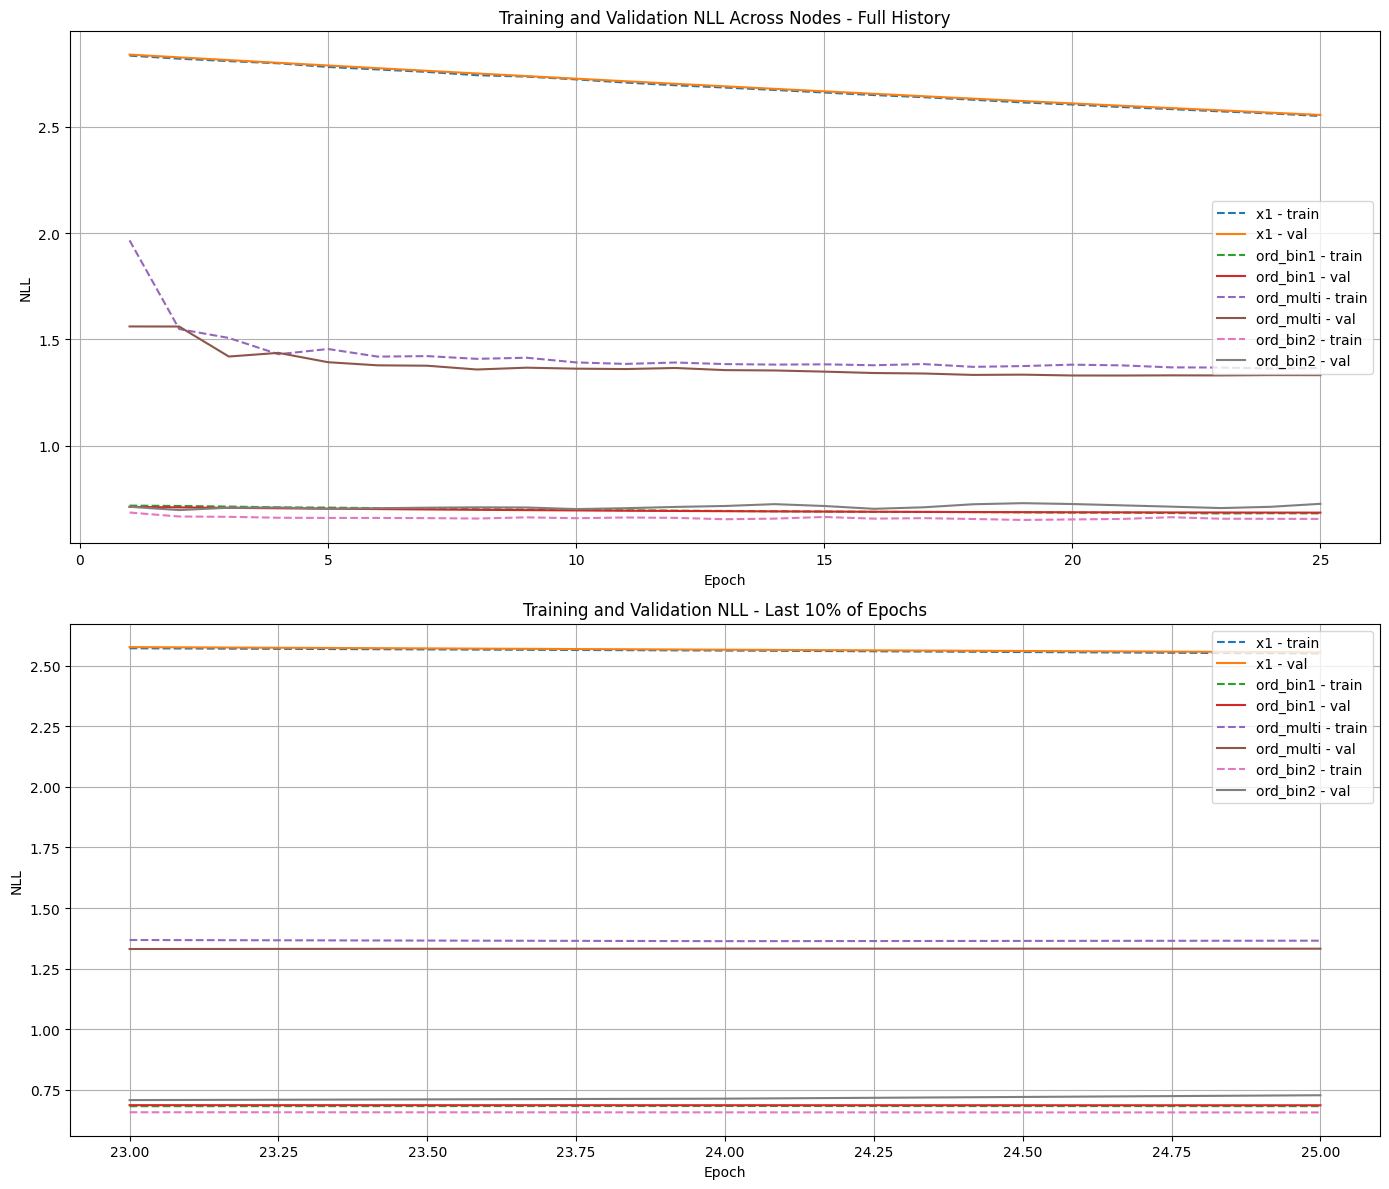

In [16]:
show_training_history(target_nodes,EXPERIMENT_DIR)

In [17]:
target_nodes

{'x1': {'Modelnr': 0,
  'data_type': 'continous',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': -1.523303818090823,
  'max': 1.7558465123350986,
  'transformation_term_nn_models_in_h()': {}},
 'ord_bin1': {'Modelnr': 1,
  'data_type': 'ordinal_Xn_Yo',
  'levels': 2,
  'node_type': 'source',
  'parents': [],
  'parents_datatype': {},
  'transformation_terms_in_h()': {},
  'min': 0.0,
  'max': 1.0,
  'transformation_term_nn_models_in_h()': {}},
 'ord_multi': {'Modelnr': 2,
  'data_type': 'ordinal_Xn_Yo',
  'levels': 4,
  'node_type': 'internal',
  'parents': ['x1', 'ord_bin1'],
  'parents_datatype': {'x1': 'continous', 'ord_bin1': 'ordinal_Xn_Yo'},
  'transformation_terms_in_h()': {'x1': np.str_('cs11'),
   'ord_bin1': np.str_('cs12')},
  'min': 0.0,
  'max': 3.0,
  'transformation_term_nn_models_in_h()': {'x1': 'ComplexShiftDefaultTabular11',
   'ord_bin1': 'ComplexShiftDefaultTabular12'}},
 'ord_bin2': {'Modelnr': 3,
 

In [18]:
from utils.sampling_tram_data import show_hdag_for_source_nodes_v3


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


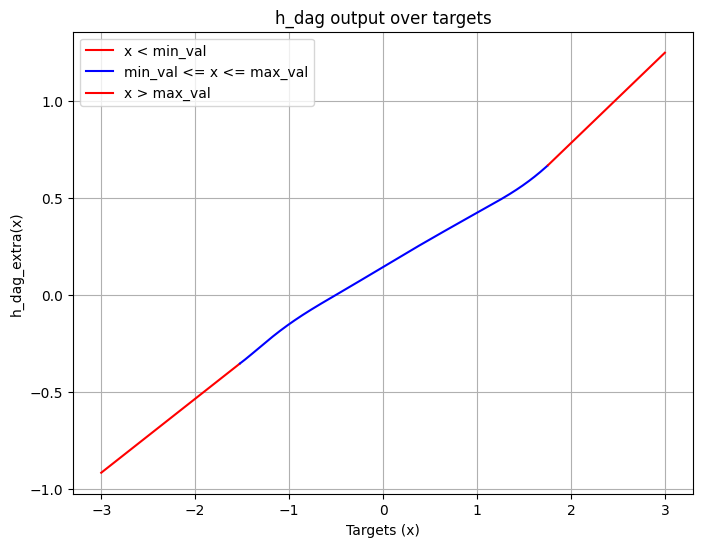


----*----------*-------------*--------Inspect TRAFO Node: ord_bin1 ------------*-----------------*-------------------*--
not implemeneted yet for ordinal (nominally encoded)

----*----------*-------------*--------Inspect TRAFO Node: ord_multi ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance

----*----------*-------------*--------Inspect TRAFO Node: ord_bin2 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [19]:
show_hdag_for_source_nodes_v3(target_nodes,EXPERIMENT_DIR,device,xmin_plot=-3,xmax_plot=3)

In [20]:
from utils.sampling_tram_data import inspect_trafo_standart_logistic_v3

In [21]:
val_df

,x1,ord_bin1,ord_multi,ord_bin2
411,-1.124642,0,1,0
621,0.471468,0,3,0
721,-1.710168,1,1,1
914,-0.095296,1,0,0
917,0.186609,1,2,0
...,...,...,...,...
554,0.337603,0,2,0
938,0.243801,1,1,0
522,-0.662624,1,0,1
677,1.752270,0,2,1


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


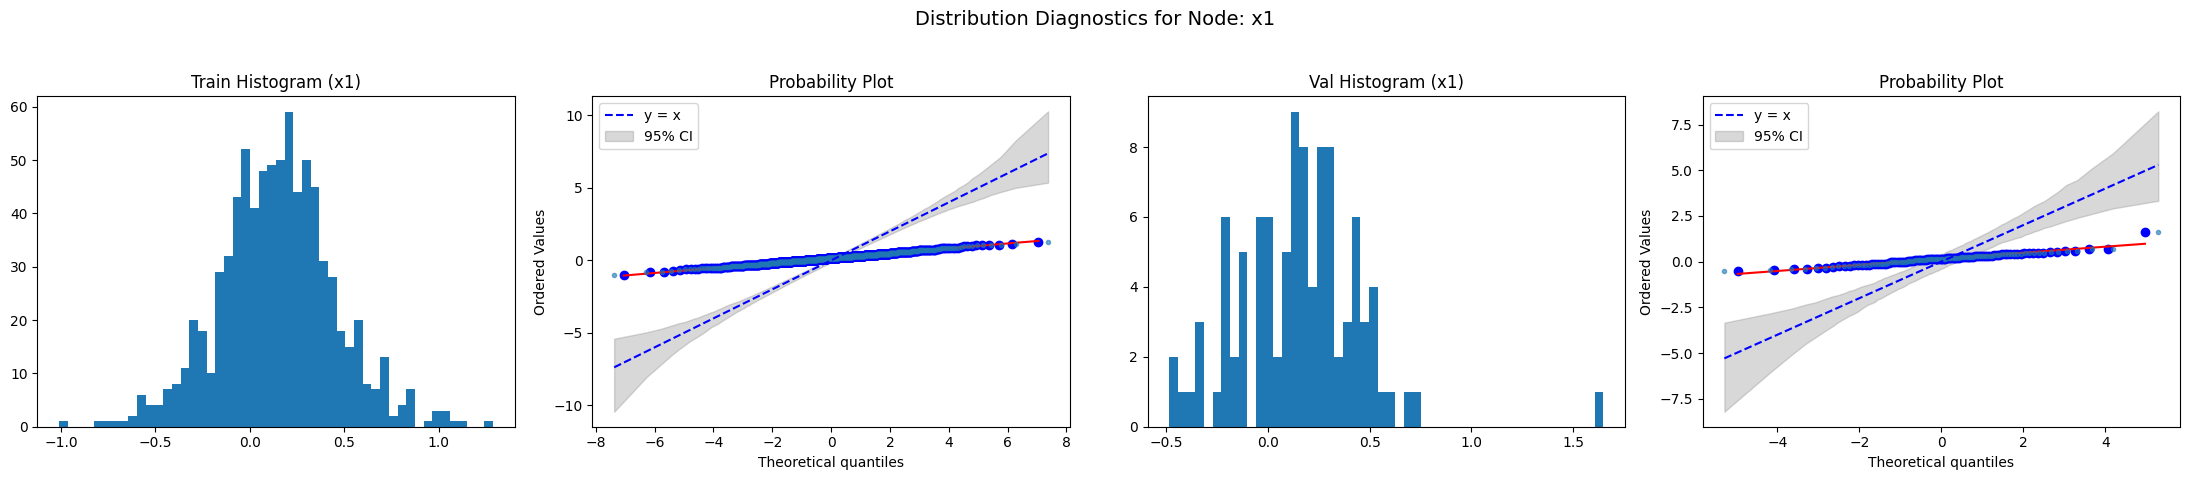

----*----------*-------------*--------h(data) should be standard logistic: ord_bin1 ------------*-----------------*-------------------*--
not defined for ordinal target variables
----*----------*-------------*--------h(data) should be standard logistic: ord_multi ------------*-----------------*-------------------*--
not defined for ordinal target variables
----*----------*-------------*--------h(data) should be standard logistic: ord_bin2 ------------*-----------------*-------------------*--
not defined for ordinal target variables


In [22]:
inspect_trafo_standart_logistic_v3(target_nodes, EXPERIMENT_DIR, train_df, val_df, device, verbose=False)


In [23]:
from utils.sampling_tram_data import *

In [24]:
target_nodes_dict=target_nodes

In [25]:
# TODO sample_full_dag_chandru for ordinal case too

In [26]:
# delete_all_previously_sampled=True
# do_interventions={}
# n= 10_000
# batch_size = 32
# delete_all_previously_sampled=True
# verbose=True



# # delete the previolusly sampled data
# if delete_all_previously_sampled:
#     delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)


# # repeat process until all nodes are sampled
# processed_nodes=[] # stack
# while set(processed_nodes) != set(target_nodes_dict.keys()): 
#     for node in target_nodes_dict: # for each node in the target_nodes_dict
#         if node in processed_nodes:
#             if verbose :
#                 print('node is already  in sampled list')
#             continue
        
#         _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes_dict)

        
#         print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
        
#         ## 1. Paths 
#         NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
#         SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
#         os.makedirs(SAMPLING_DIR, exist_ok=True)
        
        
#         ## 2. Check if sampled and latents already exist 
#         if check_sampled_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
#             processed_nodes.append(node)
#             continue
        
#         ## 3. logic to make sure parents are always sampled first
#         skipping_node = False
#         if target_nodes_dict[node]['node_type'] != 'source':
#             for parent in target_nodes_dict[node]['parents']:
#                 if not check_sampled_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
#                     skipping_node = True
#                     break
                
#         if skipping_node:
#             print(f"Skipping {node} as parent {parent} is not sampled yet.")
#             continue
        
        
        
#         ## INTERVENTION, if node is to be intervened on , data is just saved
#         if do_interventions: 
#             if node in do_interventions.keys():
#                 intervention_value = do_interventions[node]
#                 intervention_vals = torch.full((n,), intervention_value)
                
                
#                 sampled_path = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt") # TODO change the sampled chandrupatla to differnent name 
#                 torch.save(intervention_vals, sampled_path)
                
#                 ### dummy latents jsut for the check , not needed
#                 dummy_latents = torch.full((n,), float('nan'))  
#                 latents_path = os.path.join(SAMPLING_DIR, "latents.pt")
#                 torch.save(dummy_latents, latents_path)
#                 processed_nodes.append(node)
            
#         ## no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
#         else:
#             ### sampling latents
#             latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
#             #latent_sample = truncated_logistic_sample(n=n, low=0, high=1, device=device)
            
#             if verbose:
#                 print("-- sampled latents")
            
#             ### load modelweights
#             model_path = os.path.join(NODE_DIR, "best_model.pt")
#             tram_model = get_fully_specified_tram_model_v5(node, target_nodes, verbose=True).to(device)
#             tram_model.load_state_dict(torch.load(model_path))
            
#             if verbose:
#                 print("-- loaded modelweights")
            
            
#             # TODO samples for ordinal target
            
                
#             dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, target_nodes=target_nodes_dict, transform=None)
#             sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
#     break

In [27]:
# output_list = []
# with torch.no_grad():
#     for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
#         x = [xi.to(device) for xi in x]
        
#         print(f"x {x}")
#         int_input, shift_list = preprocess_inputs(x,ordered_transformation_terms_in_h.values(), device=device)
        
    
#         if int_input is not None:
#             print(f"int_input {int_input.shape}")
#         if shift_list is not None:
#             print(f"shift_list {[s.shape for s in shift_list]}") 
        
#         print([t.shape for t in x])
        
#         model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
        
#         print(f"model_outputs {model_outputs}")
        
#         output_list.append(model_outputs)
        
# if target_nodes_dict[node]['node_type'] == 'source':
#     if verbose:
#         print("source node, Defaults to SI and 1 as inputs")
#     theta_single = output_list[0]['int_out'][0]
#     theta_single = transform_intercepts_continous(theta_single)
#     thetas_expanded = theta_single.repeat(n, 1)
#     shifts = torch.zeros(n, device=device)
# else:
#     if verbose:
#         print("node has parents, previously sampled data is loaded for each pa(node)")
#     y_pred = merge_outputs(output_list, skip_nan=True)
#     shifts = y_pred['shift_out']
#     if shifts is None:
#         print("shift_out was None; defaulting to zeros.")
#         shifts = torch.zeros(n, device=device)
#     thetas = y_pred['int_out']
#     thetas_expanded = transform_intercepts_continous(thetas).squeeze()
#     shifts = shifts.squeeze()

In [28]:
do_interventions={}
if do_interventions:
    print(1)

In [29]:
# def create_df_from_sampled(node,target_nodes_dict,SAMPLING_DIR):
#     sampling_dict={}
#     for parent in target_nodes_dict[node]['parents']:
#         sampled=torch.load(os.path.join(SAMPLING_DIR,f"sampled.pt"))
#         sampling_dict[parent]=sampled
#     sampling_df=pd.DataFrame(sampling_dict)
#     return sampling_df




# def criteria_for_continous_modelled_outcome(node,target_nodes_dict):
#     if 'yc'in target_nodes_dict[node]['data_type'].lower() or 'continous' in target_nodes_dict[node]['data_type'].lower():
#         return True
#     else:
#         return False

# def criteria_for_ordinal_modelled_outcome(node,target_nodes_dict):
#     if 'yo'in target_nodes_dict[node]['data_type'].lower() and 'ordinal' in target_nodes_dict[node]['data_type'].lower():
#         return True
#     else:
#         return False  
    
    
# def sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample):
    
#     _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes_dict)
#     output_list = []
#     with torch.no_grad():
#         for x in tqdm(sample_loader, desc=f"h() for samples in  {node}"):
#             # x = [xi.to(device) for xi in x]
            
#             # print(f"x {x}")
#             # int_input, shift_list = preprocess_inputs_v2(x,ordered_transformation_terms_in_h.values(), device=device)
            
        
#             if int_input is not None:
#                 print(f"int_input {int_input.shape}")
#             if shift_list is not None:
#                 print(f"shift_list {[s.shape for s in shift_list]}") 
            
#             print([t.shape for t in x])
            
#             model_outputs = tram_model(int_input=int_input, shift_input=shift_list)
            
#             print(f"model_outputs {model_outputs}")
            
#             output_list.append(model_outputs)
            
#     if target_nodes_dict[node]['node_type'] == 'source':
#         if verbose:
#             print("source node, Defaults to SI and 1 as inputs")
#         theta_single = output_list[0]['int_out'][0]
#         theta_single = transform_intercepts_continous(theta_single)
#         thetas_expanded = theta_single.repeat(n, 1)
#         shifts = torch.zeros(n, device=device)
#     else:
#         if verbose:
#             print("node has parents, previously sampled data is loaded for each pa(node)")
#         y_pred = merge_outputs(output_list, skip_nan=True)
#         shifts = y_pred['shift_out']
#         if shifts is None:
#             print("shift_out was None; defaulting to zeros.")
#             shifts = torch.zeros(n, device=device)
#         thetas = y_pred['int_out']
#         thetas_expanded = transform_intercepts_continous(thetas).squeeze()
#         shifts = shifts.squeeze()
    
#     low = torch.full((n,), -1e5, device=device)
#     high = torch.full((n,), 1e5, device=device)
#     min_vals = torch.tensor(target_nodes_dict[node]['min'], dtype=torch.float32).to(device)
#     max_vals = torch.tensor(target_nodes_dict[node]['max'], dtype=torch.float32).to(device)
#     min_max = torch.stack([min_vals, max_vals], dim=0)
    
#     ## Root finder using Chandrupatla's method
#     def f_vectorized(targets):
#         return vectorized_object_function(
#             thetas_expanded,
#             targets,
#             shifts,
#             latent_sample,
#             k_min=min_max[0],
#             k_max=min_max[1]
#         )
        
#     sampled = chandrupatla_root_finder(
#         f_vectorized,
#         low,
#         high,
#         max_iter=10_000,
#         tol=1e-9
#     )
#     return sampled
    
    
    
# def sample_ordinal_modelled_target(node,target_nodes_dict,sample_loader,tram_model):
#     print('not implemented yet')

In [30]:
# def sample_full_dag_chandru_v2(target_nodes_dict,
#                             EXPERIMENT_DIR,
#                             device,
#                             do_interventions={},
#                             n= 10_000,
#                             batch_size = 32,
#                             delete_all_previously_sampled=True,
#                             verbose=True):
#     """
#     Samples data for all nodes in a DAG defined by `conf_dict`, ensuring that each node's
#     parents are sampled before the node itself. Supports interventions on any subset of nodes.

#     Parameters
#     ----------
#     conf_dict : dict
#         Dictionary defining the DAG. Each key is a node name, and each value is a config
#         dict that includes at least:
#             - 'node_type': str, either 'source' or other
#             - 'parents': list of parent node names
#             - 'min': float, minimum allowed value for the node
#             - 'max': float, maximum allowed value for the node

#     EXPERIMENT_DIR : str
#         Base directory where all per-node directories are located.

#     device : torch.device
#         The device to run computations on (e.g., 'cuda' or 'cpu').

#     do_interventions : dict, optional
#         A dictionary specifying interventions for some nodes. Keys are node names (str),
#         values are floats. For each intervened node, the specified value is used as the
#         sampled value for all samples, and the model is bypassed. e.g. {'x1':1.0}

#     n : int, optional
#         Number of samples to draw for each node (default is 10_000).

#     batch_size : int, optional
#         Batch size for model evaluation during sampling (default is 32).

#     delete_all_previously_sampled : bool, optional
#         If True, removes previously sampled data before starting (default is True).

#     verbose : bool, optional
#         If True, prints debug/status information (default is True).

#     Notes
#     -----
#     - The function ensures that nodes are only sampled after their parents.
#     - Nodes with `node_type='source'` are treated as having no parents.
#     - If a node is in `do_interventions`, `sampled_chandrupatla.pt` and a dummy `latents.pt`
#       are created, enabling downstream nodes to proceed.
#     - Sampling is done using a vectorized root-finding method (Chandrupatla's algorithm).
#     """


#     # delete the previolusly sampled data
#     if delete_all_previously_sampled:
#         delete_all_samplings(target_nodes_dict, EXPERIMENT_DIR)
    
    
#     # repeat process until all nodes are sampled
#     processed_nodes=[] # log the processed nodes in this list
#     while set(processed_nodes) != set(target_nodes_dict.keys()): 
#         for node in target_nodes_dict: # for each node in the target_nodes_dict
#             if node in processed_nodes:
#                 if verbose :
#                     print('node is already  in sampled list')
#                 continue
                        
#             print(f'\n----*----------*-------------*--------Sample Node: {node} ------------*-----------------*-------------------*--') 
            
#             ## 1. Paths 
#             NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
#             SAMPLING_DIR = os.path.join(NODE_DIR, 'sampling')
#             os.makedirs(SAMPLING_DIR, exist_ok=True)
#             SAMPLED_PATH = os.path.join(SAMPLING_DIR, "sampled_chandrupatla.pt")
#             LATENTS_PATH = os.path.join(SAMPLING_DIR, "latents.pt")
            
            
#             ## 2. Check if sampled and latents already exist 
#             if check_sampled_and_latents(NODE_DIR, rootfinder='chandrupatla', verbose=verbose):
#                 processed_nodes.append(node)
#                 continue
            
#             ## 3. logic to make sure parents are always sampled first
#             skipping_node = False
#             if target_nodes_dict[node]['node_type'] != 'source':
#                 for parent in target_nodes_dict[node]['parents']:
#                     if not check_sampled_and_latents(os.path.join(EXPERIMENT_DIR, parent), rootfinder='chandrupatla', verbose=verbose):
#                         skipping_node = True
#                         break
                    
#             if skipping_node:
#                 print(f"Skipping {node} as parent {parent} is not sampled yet.")
#                 continue
            
            
#             ## INTERVENTION, if node is to be intervened on , data is just saved
#             if do_interventions and node in do_interventions.keys():
#                     # For interventions make all the values the same for 
#                     intervention_value = do_interventions[node]
#                     intervention_vals = torch.full((n,), intervention_value)
#                     torch.save(intervention_vals, SAMPLED_PATH)
                    
#                     ### dummy latents jsut for the check , not needed
#                     dummy_latents = torch.full((n,), float('nan'))  
#                     torch.save(dummy_latents, LATENTS_PATH)
#                     processed_nodes.append(node)
#                     print(f'Interventional data for node {node} is saved')
#                     continue
                
#             ##### %%%%%%% no intervention, based on the sampled data from the parents though the latents for each node the observational distribution is generated    
#             else:
#                 ### sampling latents
#                 latent_sample = torch.tensor(logistic.rvs(size=n), dtype=torch.float32).to(device)
                
#                 ### load modelweights
#                 MODEL_PATH = os.path.join(NODE_DIR, "best_model.pt")
#                 tram_model = get_fully_specified_tram_model_v5(node, target_nodes, verbose=True).to(device)
#                 tram_model.load_state_dict(torch.load(MODEL_PATH))

                
                
#                 # isntead of sample loader use Generic Dataset but the df is just to sampled data from befor -> create df on the fly
#                 sampled_df=create_df_from_sampled(node,target_nodes_dict,SAMPLING_DIR)
                
    
#                 transform = transforms.Compose([
#                     transforms.Resize((128, 128)),
#                     transforms.ToTensor()
#                 ])

#                 ordered_parents_dataype_dict, ordered_transformation_terms_in_h, _ = ordered_parents(node, target_nodes)
                    
#                 sample_dataset = GenericDataset_v5(sampled_df,target_col=node,
#                                                    target_nodes=target_nodes,
#                                                    parents_dataype_dict=ordered_parents_dataype_dict,
#                                                    transform=transform,transformation_terms_in_h=ordered_transformation_terms_in_h,
#                                                    return_intercept_shift=return_intercept_shift,
#                                                    return_y=False)
                
#                 sample_loader = DataLoader(sample_dataset, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
                
                
                
#                 # # dataset = SamplingDataset(node=node, EXPERIMENT_DIR=EXPERIMENT_DIR, rootfinder='chandrupatla', number_of_samples=n, target_nodes=target_nodes_dict, transform=None)
#                 # sample_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
                
                
#                 ###*************************************************** Continous Modelled Outcome ************************************************
                
#                 if criteria_for_continous_modelled_outcome(node,target_nodes_dict):
#                     sampled=sample_continous_modelled_target(node,target_nodes_dict,sample_loader,tram_model,latent_sample)
                    
#                 ###*************************************************** Ordinal Modelled Outcome ************************************************
                
#                 if criteria_for_ordinal_modelled_outcome(node,target_nodes_dict):
#                     sampled=sample_ordinal_modelled_target(node,target_nodes_dict,sample_loader,tram_model)
                
#                 else:
#                     raise ValueError(f"Unsupported data_type '{target_nodes_dict[node]['data_type']}' for node '{node}' in sampling.")
                    
                    
#                 ###*************************************************** Saving the latenst and sampled  ************************************************
#                 if torch.isnan(sampled).any():
#                     print(f'Caution! Sampling for {node} consists of NaNs')
                    
#                 torch.save(sampled, SAMPLED_PATH)
#                 torch.save(latent_sample, LATENTS_PATH)
                
#                 processed_nodes.append(node)
                
                